# NTSAR 

In [4]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Minimum embedding dimension

## Time lag

In [ ]:
library()

## Visibility Graph

In [11]:
natural_visibility_graph <- function(time_series) {
  fast_VG(time_series, 1, length(time_series)) %>%
    tibble::rownames_to_column() %>%
    group_by(rowname) %>%
    mutate(vrtx_out = min(v1, v2),
           vrtx_in = max(v1, v2)) %>%
    ungroup() %>%
    select(vrtx_out, vrtx_in) %>%
    filter(vrtx_out != vrtx_in) %>%
    arrange(vrtx_out, vrtx_in) %>%
    mutate(view_angle =  atan((time_series[vrtx_in] - time_series[vrtx_out])/(vrtx_in - vrtx_out))) %>%
    igraph::graph_from_data_frame() %>%
    return()
}

fast_VG <- function(ts, left, right) {
  if (left < right ) {
    ts_tmp <- ts[left:right]
    k <-  which(ts_tmp == max(ts_tmp))[1] + left - 1

    tibble(v1 = k,
           v2 = left:right,
           is_connected =
             left:right %>%
             map(~nodes_visibility(ts,k,.x)) %>%
             unlist()
           ) %>%
      filter(is_connected == TRUE) %>%
      bind_rows(fast_VG(ts, left, k - 1),
                fast_VG(ts, k + 1, right)) %>%
      return()
  }
  else{
    return(tibble())
  }
}

nodes_visibility <- function(ts, i, j) {

  visibility_condition <- TRUE
  if (j > length(ts)) {
    warning("Too long!")
    return(NaN)
  }

  if (i == j) {
    return(visibility_condition)
  }

  if (i > j) {
    return(nodes_visibility(rev(ts), length(ts) - i + 1, length(ts) - j + 1))
  }

  ii <- i + 1
  while (visibility_condition) {
    if (ii == j) {break}
    visibility_condition <- ts[ii] <= ts[j] + (ts[i] - ts[j]) * ((j - ii)/(j - i))
    ii <- ii + 1
  }
  return(visibility_condition)
}

# horizontal visibility ---------------------------------------------------

horizontal_visibility_graph <- function(ts) {
  res_list <- map(1:length(ts), ~horizontal_visibility(ts, .x, length(ts)))

  matrix(c(map(1:length(res_list),
               ~rep(.x,length(res_list[[.x]]))) %>% flatten_int(),
           res_list %>% flatten_int()),
         nc = 2) %>%
    igraph::graph_from_edgelist() %>%
    return()
}

horizontal_visibility <- function(ts, left, right) {
  result <- c( )
  k <- first_greater(ts, left, right)
  while (!is.null(k)) {
    result <- c(result, k)
    k <-  max_val_ts(ts,left,k)
  }
  return(result)
}

first_greater <- function(ts, left, right) {
  ts_tmp <- ts[left:right]
  if (ts[left] == max(ts[left:right])) {
    return(right)
  }
  else{
    return(as.integer(which(ts_tmp > ts_tmp[1])[1] + left - 1) )
  }
}

max_val_ts <- function(ts, left, right) {

  if ((right - left) > 1) {
      ts_tmp <- ts[(left + 1):(right - 1)]
      return(which(ts_tmp == max(ts_tmp))[1] + left)
  }

  else {
    return(NULL)
  }
}


# time_series <- ts
# df <- fast_VG(time_series, 1, length(time_series)) %>%
#   tibble::rownames_to_column() %>%
#   group_by(rowname) %>%
#   mutate(vrtx_out = min(v1, v2),
#          vrtx_in = max(v1, v2)) %>%
#   ungroup() %>%
#   select(vrtx_out, vrtx_in) %>%
#   filter(vrtx_out != vrtx_in) %>%
#   arrange(vrtx_out, vrtx_in)
#
# visibility_angle <- atan(ts[df$vrtx_in] - ts[df$vrtx_out])/(df$vrtx_in - df$vrtx_out)

## Transition Network

[1] 0,04863222 0,03951368 0,03444782 0,02634245 0,02127660 0,01621074
 [7] 0,02836879 0,02431611 0,03546099 0,02228977 0,02836879 0,02330294
[13] 0,02735562 0,02735562 0,02836879 0,03444782 0,02431611 0,02127660
[19] 0,02431611 0,02228977 0,02026342 0,02836879 0,04255319 0,03140831
[25] 0,03647416 0,02735562 0,02330294 0,03140831 0,02127660 0,02836879
[31] 0,02026342 0,02127660 0,02127660 0,02634245 0,03140831 0,03039514

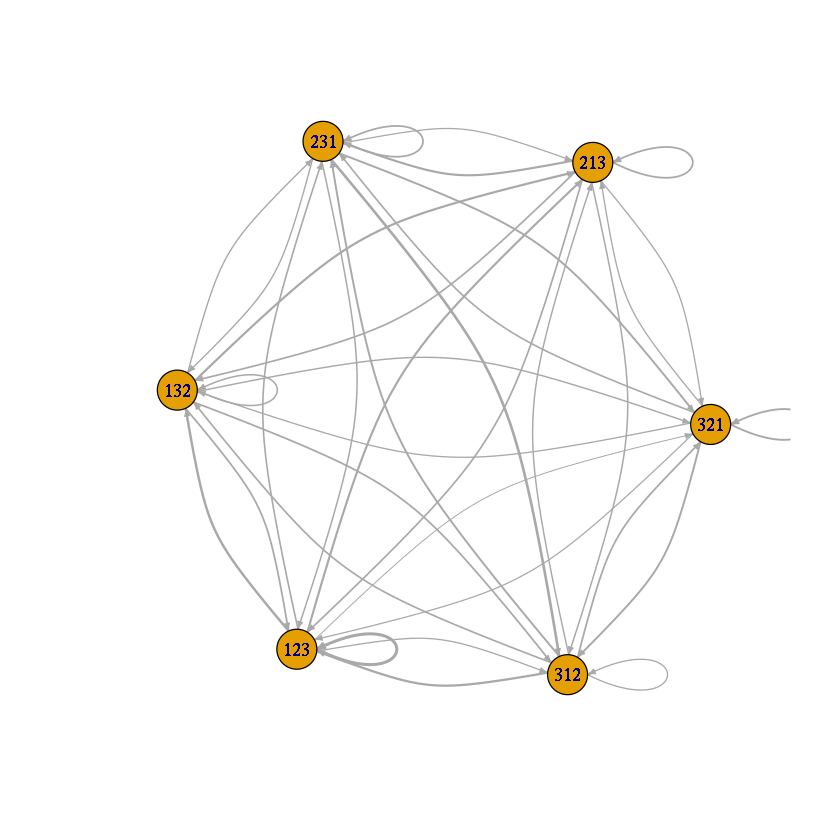

In [12]:
t <- 4
m <- 3

ts <- sin((1:1000)/30) + runif(1000)

ordinal_patterns <-
  1:(length(ts)-t*m) %>%
  map(~ts[seq(.x, .x+(m*t-1), t)] %>%
        rank %>%
        invoke(str_c, .)) %>%
  as_vector()

gg <- tibble(vrtx_out = ordinal_patterns[1:(length(ordinal_patterns)-1)],
             vrtx_in = ordinal_patterns[2:length(ordinal_patterns)]) %>%
  group_by(vrtx_out, vrtx_in) %>%
  summarise(count = n()) %>%
  ungroup() %>%
  mutate(count = count/sum(count)) %>%
  igraph::graph_from_data_frame()


igraph::get.edge.attribute(gg)$count

plot(gg, edge.curved=.3, edge.arrow.size=.3, edge.width =
       igraph::get.edge.attribute(gg)$count*50)


## Recurrence analysis

In [13]:
recurrence_matrix <- function(ts, eps) {
  recurrence_mat <- matrix(0, length(ts), length(ts))

  for (ii in 1:length(ts)) {
    recurrence_mat[ii,] <- abs(ts - ts[ii]) < eps
  }

  return(recurrence_mat)
}

## Simple measures

### Sample/Approximate/Fuzzy Entropy

### Permutation entropy

In [6]:
ts <- rnorm(100, 1, 1)
emb_dim <- 5
t_lag <- 1

In [8]:
map(1:(length(ts) - emb_dim), ~(ts[seq(.x, emb_dim + .x, t_lag) %>% rank])

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: nieoczekiwany koniec wejścia
1: map(1:(length(ts) - emb_dim), ~(ts[seq(.x, emb_dim + .x, t_lag) %>% rank])
   ^


### Rescaled range

### Multifractal detrended fluctuation analysis

### Porta/Guzik index

In [14]:
porta_index <- function(ts, t_embd = 1) {
  ts_diff <- diff(ts, lag = t_embd)
  (length(ts_diff[ts_diff<0])/length(ts_diff[ts_diff!=0])) %>%
    return()
}

guzik_index <- function(ts, t_embd = 1) {
  ts_diff <- diff(ts, lag = t_embd)
  ((ts_diff[ts_diff>=0]^2 %>% sum)/(ts_diff^2 %>% sum)) %>%
    return()
}

ehler_index <- function(ts, t_embd = 1) {
  diff_ts <- diff(ts, lag = t_embd)

  sum(diff_ts^3)/((sum(diff_ts^2))^(3/2)) %>%
    return()
}

shannon_entrophy <- function(p) {
  return(-sum(p*log(p)))
}

poincare_plot <- function(ts, t_embd = 1) {
  tibble(x = ts[1:(length(ts)-t_embd)],
         y = ts[(t_embd+1):length(ts)]) %>%
    ggplot(aes(x,y)) +
    geom_point() %>%
    return()
}

### Permutation patterns